# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-d5asegmm
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-d5asegmm
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [ ]:
!unzip /content/tiff_dataset.zip

In [ ]:
import os
img_files = os.listdir("/content/tiff_dataset/images")
img_files.sort()
mask_files = os.listdir("/content/tiff_dataset/masks")
mask_files.sort()

In [ ]:
len(img_files)

16

In [ ]:
import csv

# open the file in the write mode
with open('/content/train.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(['Images','Masks'])

    for i in range(len(img_files)):
      writer.writerow([img_files[i],mask_files[i]])


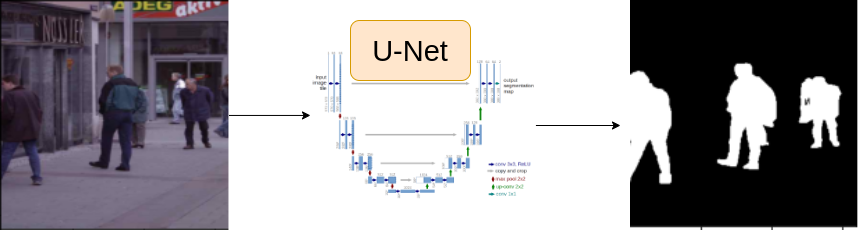

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2
from PIL import Image
import albumentations as A

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helpfunc

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/train.csv"
DATA_DIR = "/content/"

DEVICE = 'cuda'

EPOCHS = 100
LR = 0.003
IMAGE_SIZE = 224
BATCH_SIZE = 2

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [ ]:
cd /content/anomaly_dataset

[Errno 2] No such file or directory: '/content/anomaly_dataset'
/content


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Images,Masks
0,grid_test_bent_000.tiff,grid_test_bent_000.png
1,grid_test_bent_001.tiff,grid_test_bent_001.png
2,grid_test_bent_002.tiff,grid_test_bent_002.png
3,grid_test_broken_000.tiff,grid_test_broken_000.png
4,grid_test_broken_001.tiff,grid_test_broken_001.png


In [ ]:
row = df.iloc[4]

image_path = os.path.join('/content/tiff_dataset/images',row.Images)


mask_path = os.path.join('/content/tiff_dataset/masks',row.Masks)

image = Image.open(image_path)


image = np.array(image)

#image = cv2.imread(image_path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = Image.open(mask_path)
mask = np.array(mask)/255.0

mask_transform = A.Compose([
            A.Resize(400,400, interpolation=cv2.INTER_NEAREST),
            A.CenterCrop(224,224)
            ])
mask = mask_transform(image=mask)['image']
#mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

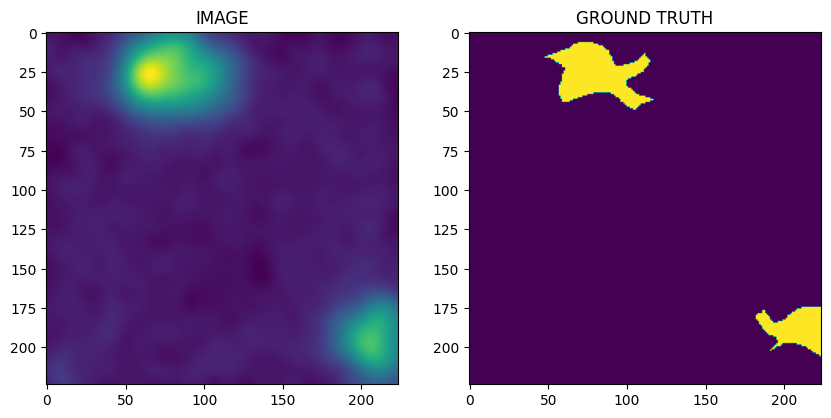

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
#ax2.imshow(mask,cmap = 'gray')
ax2.imshow(mask)

In [ ]:
train_df, valid_df = train_test_split(df, test_size =0.4, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes =False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ],is_check_shapes =False) 

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = os.path.join('/content/tiff_dataset/images',row.Images)
    #print(image_path)
    mask_path = os.path.join('/content/tiff_dataset/masks',row.Masks)
    #print(mask_path)

    # image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = Image.open(image_path)
    image = np.array(image)


    # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # mask = np.expand_dims(mask,axis=-1)
    mask = Image.open(mask_path)
    mask = np.array(mask)/255.0

    mask_transform = A.Compose([
                A.Resize(400,400, interpolation=cv2.INTER_NEAREST),
                A.CenterCrop(224,224)
                ])
    mask = mask_transform(image=mask)['image']


    if self.augmentations:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']


    #(h,w,c) -> (c,h,w)
    #image = np.transpose(image,(2,0,1)).astype(np.float32)
    #mask= np.transpose(mask,(2,0,1)).astype(np.float32)

    #image = torch.Tensor(image)/255.0
    #mask = torch.round(torch.Tensor(mask)/255.0)
    #mask = (torch.Tensor(mask)/255.0)
    
    image = torch.Tensor(image)
    mask = torch.Tensor(mask)
    return image,mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 9
Size of Validset : 7


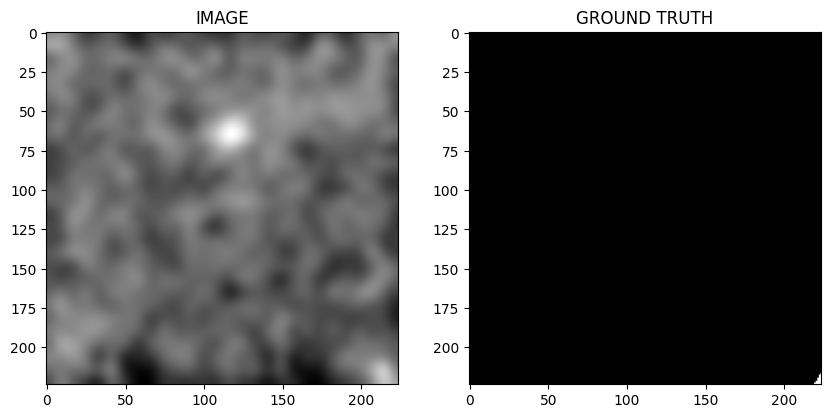

In [ ]:

idx = 5
image,mask = trainset[idx]
helpfunc.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in train loader: {len(trainloader)}")
print(f"Total no. of batches in valid loader: {len(validloader)}")

Total no. of batches in train loader: 5
Total no. of batches in valid loader: 4


In [ ]:
for image,mask in validloader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([2, 224, 224])
One batch mask shape: torch.Size([2, 224, 224])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss,FocalLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 1,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits = self.arc(images)

    if masks!=None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      loss = FocalLoss(mode='binary')(logits,masks)
      return logits, loss1 + loss2
      #return logits, loss
    
    return logits 



In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):

    images = images.unsqueeze(1).to(DEVICE)
    masks = masks.unsqueeze(1).to(DEVICE)

    #print(images.shape)
    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)  


In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):

      images = images.unsqueeze(1).to(DEVICE)
      masks = masks.unsqueeze(1).to(DEVICE)

      optimizer.zero_grad()
      logits,loss = model(images,masks)

      total_loss+=loss.item()

    return total_loss/len(data_loader)  

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)


  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss  =valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss:{valid_loss}')

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 60%|██████    | 3/5 [00:01<00:00,  2.51it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 34.34it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 1.4944177150726319 Valid_loss:0.980027437210083


 40%|████      | 2/5 [00:00<00:00, 15.65it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.23it/s]


Epoch: 2 Train_loss: 1.154579496383667 Valid_loss:0.9956263825297356


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.69it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.61it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 36.04it/s]


Epoch: 3 Train_loss: 0.9662439823150635 Valid_loss:1.0038252994418144


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.22it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.71it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.67it/s]


SAVED-MODEL
Epoch: 4 Train_loss: 0.8413853406906128 Valid_loss:0.8574056755751371


 40%|████      | 2/5 [00:00<00:00, 18.15it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.05it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 37.24it/s]


SAVED-MODEL
Epoch: 5 Train_loss: 0.7232268810272217 Valid_loss:0.8063074946403503


 40%|████      | 2/5 [00:00<00:00, 18.41it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.44it/s]


SAVED-MODEL
Epoch: 6 Train_loss: 0.5321626842021943 Valid_loss:0.7673296807333827


 40%|████      | 2/5 [00:00<00:00, 17.01it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.44it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 37.66it/s]


Epoch: 7 Train_loss: 0.5742224097251892 Valid_loss:0.7691784580238163


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.85it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.60it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.06it/s]


SAVED-MODEL
Epoch: 8 Train_loss: 0.4394543170928955 Valid_loss:0.765115903574042


 40%|████      | 2/5 [00:00<00:00, 17.51it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.96it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.14it/s]


Epoch: 9 Train_loss: 0.3390804648399353 Valid_loss:0.7671413818607107


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.63it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.47it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.67it/s]


SAVED-MODEL
Epoch: 10 Train_loss: 0.46440715789794923 Valid_loss:0.7010763121943455


 40%|████      | 2/5 [00:00<00:00, 17.52it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.98it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.22it/s]


SAVED-MODEL
Epoch: 11 Train_loss: 0.37104788720607756 Valid_loss:0.6354284745320911


 40%|████      | 2/5 [00:00<00:00, 16.85it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.46it/s]


SAVED-MODEL
Epoch: 12 Train_loss: 0.47191840410232544 Valid_loss:0.628712142141012


 40%|████      | 2/5 [00:00<00:00, 16.62it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.78it/s]


SAVED-MODEL
Epoch: 13 Train_loss: 0.37803696691989896 Valid_loss:0.6037865445323405


 40%|████      | 2/5 [00:00<00:00, 17.66it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.20it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.02it/s]


Epoch: 14 Train_loss: 0.46644348502159116 Valid_loss:0.6377849689270079


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.51it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.56it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 40.41it/s]


Epoch: 15 Train_loss: 0.41909279823303225 Valid_loss:0.7065496397190145


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.18it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.34it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 41.39it/s]


SAVED-MODEL
Epoch: 16 Train_loss: 0.23320379294455051 Valid_loss:0.6033168919202581


 40%|████      | 2/5 [00:00<00:00, 17.14it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.27it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 39.03it/s]


Epoch: 17 Train_loss: 0.3041583806276321 Valid_loss:0.6200818339602847


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.87it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.71it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.63it/s]


Epoch: 18 Train_loss: 0.3033046988537535 Valid_loss:0.6261102319040219


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.23it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.41it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 43.69it/s]


SAVED-MODEL
Epoch: 19 Train_loss: 0.29067745208740237 Valid_loss:0.5993065126604051


 40%|████      | 2/5 [00:00<00:00, 16.12it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.91it/s]


Epoch: 20 Train_loss: 0.4096563756465912 Valid_loss:0.7004509582620813


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.68it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.62it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.06it/s]


Epoch: 21 Train_loss: 0.4405900061130524 Valid_loss:0.7038075665914221


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.52it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.49it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.25it/s]


Epoch: 22 Train_loss: 0.3138926237821579 Valid_loss:0.6196636836975813


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.75it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.56it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.41it/s]


Epoch: 23 Train_loss: 0.3683342307806015 Valid_loss:0.5993814261164516


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 13.87it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 29.51it/s]


SAVED-MODEL
Epoch: 24 Train_loss: 0.3414777159690857 Valid_loss:0.5929387458309066


 40%|████      | 2/5 [00:00<00:00, 13.95it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 27.44it/s]


Epoch: 25 Train_loss: 0.34556120038032534 Valid_loss:0.5933857993222773


 40%|████      | 2/5 [00:00<00:00, 12.78it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 31.21it/s]


SAVED-MODEL
Epoch: 26 Train_loss: 0.34089115262031555 Valid_loss:0.5892584216780961


 40%|████      | 2/5 [00:00<00:00, 12.42it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 26.51it/s]


SAVED-MODEL
Epoch: 27 Train_loss: 0.3727703928947449 Valid_loss:0.5850660821888596


 40%|████      | 2/5 [00:00<00:00, 11.26it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 13.56it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 39.14it/s]


Epoch: 28 Train_loss: 0.23685422353446484 Valid_loss:0.5914311183150858


 40%|████      | 2/5 [00:00<00:00, 17.86it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.58it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.83it/s]


Epoch: 29 Train_loss: 0.3405752211809158 Valid_loss:0.6097490649844985


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.27it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.17it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 38.39it/s]


Epoch: 30 Train_loss: 0.2557702034711838 Valid_loss:0.645629994571209


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.05it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.08it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.86it/s]


Epoch: 31 Train_loss: 0.40975999236106875 Valid_loss:1.261375978589058


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.16it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.30it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.72it/s]


Epoch: 32 Train_loss: 0.4722151577472687 Valid_loss:0.5964916924131103


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 15.92it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.65it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.09it/s]


Epoch: 33 Train_loss: 0.3582835108041763 Valid_loss:1.0400734543800354


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.52it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.69it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 38.57it/s]


Epoch: 34 Train_loss: 0.3031834900379181 Valid_loss:0.5923026734963059


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.43it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.27it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.93it/s]


Epoch: 35 Train_loss: 0.336290118098259 Valid_loss:0.6014200918143615


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.33it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.70it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.00it/s]


Epoch: 36 Train_loss: 0.4847604215145111 Valid_loss:0.6003230375645217


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.23it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.60it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.58it/s]


Epoch: 37 Train_loss: 0.287091264128685 Valid_loss:0.606666122796014


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.48it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.11it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.46it/s]


Epoch: 38 Train_loss: 0.31809223294258115 Valid_loss:0.6032968650979456


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.15it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.88it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.50it/s]


Epoch: 39 Train_loss: 0.346966540813446 Valid_loss:0.6241979785263538


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.58it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.37it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.62it/s]


Epoch: 40 Train_loss: 0.2956786394119263 Valid_loss:0.5969395819120109


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.42it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.30it/s]


Epoch: 41 Train_loss: 0.462016561627388 Valid_loss:0.6041533569587045


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.15it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.63it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.11it/s]


Epoch: 42 Train_loss: 0.3095305025577545 Valid_loss:0.6540753096342087


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.77it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.49it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 42.66it/s]


Epoch: 43 Train_loss: 0.4454423516988754 Valid_loss:0.6500215493142605


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.62it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.90it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.79it/s]


Epoch: 44 Train_loss: 0.26215667426586153 Valid_loss:0.6243155046831816


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.68it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.70it/s]


Epoch: 45 Train_loss: 0.2790586441755295 Valid_loss:0.6201335922814906


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.40it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.08it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 40.78it/s]


Epoch: 46 Train_loss: 0.2947623133659363 Valid_loss:0.6242088936269283


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.99it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.45it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.08it/s]


Epoch: 47 Train_loss: 0.37591209411621096 Valid_loss:0.6021936674515018


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.57it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.12it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.07it/s]


Epoch: 48 Train_loss: 0.45889902114868164 Valid_loss:0.6403690502047539


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.51it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.88it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 39.27it/s]


Epoch: 49 Train_loss: 0.34386583864688874 Valid_loss:0.5931034367822576


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.06it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.53it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.47it/s]


Epoch: 50 Train_loss: 0.3543185830116272 Valid_loss:0.6589260030596051


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.29it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.98it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 36.35it/s]


Epoch: 51 Train_loss: 0.3387279510498047 Valid_loss:0.9417704641819


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 15.34it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.44it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.99it/s]


Epoch: 52 Train_loss: 0.41027380526065826 Valid_loss:0.8348192200064659


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 12.04it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 31.50it/s]


Epoch: 53 Train_loss: 0.48436599373817446 Valid_loss:0.6074589975178242


 40%|████      | 2/5 [00:00<00:00, 13.48it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 29.35it/s]


Epoch: 54 Train_loss: 0.328299281001091 Valid_loss:0.6013740389607847


 40%|████      | 2/5 [00:00<00:00, 13.34it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 13.75it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 31.43it/s]


Epoch: 55 Train_loss: 0.3537614822387695 Valid_loss:0.6003856807947159


 40%|████      | 2/5 [00:00<00:00, 13.74it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 29.91it/s]


Epoch: 56 Train_loss: 0.2743014544248581 Valid_loss:0.6353525184094906


 40%|████      | 2/5 [00:00<00:00, 12.41it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 26.90it/s]


Epoch: 57 Train_loss: 0.28855983912944794 Valid_loss:0.6354236602783203


 40%|████      | 2/5 [00:00<00:00, 13.18it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.04it/s]


Epoch: 58 Train_loss: 0.23707466721534728 Valid_loss:0.6419296711683273


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.00it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.36it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.76it/s]


Epoch: 59 Train_loss: 0.3094304293394089 Valid_loss:0.5906685878435383


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.72it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.30it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 38.25it/s]


Epoch: 60 Train_loss: 0.2987689107656479 Valid_loss:0.5868705279826827


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.27it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.28it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.38it/s]


Epoch: 61 Train_loss: 0.34099666476249696 Valid_loss:0.6046210253261961


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.68it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.14it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 38.12it/s]


Epoch: 62 Train_loss: 0.31042289137840273 Valid_loss:0.5991560700858827


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.20it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.66it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 43.12it/s]


Epoch: 63 Train_loss: 0.24257837384939193 Valid_loss:0.6138793145437376


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.46it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.73it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.90it/s]


Epoch: 64 Train_loss: 0.3029546797275543 Valid_loss:0.7879107743501663


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.00it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.50it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.00it/s]


Epoch: 65 Train_loss: 0.31060193479061127 Valid_loss:0.740956112742424


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.84it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.47it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 36.49it/s]


Epoch: 66 Train_loss: 0.31019038558006284 Valid_loss:0.7009235471487045


 40%|████      | 2/5 [00:00<00:00, 17.30it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.12it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 35.65it/s]


Epoch: 67 Train_loss: 0.2949804216623306 Valid_loss:0.6206515543162823


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.10it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.66it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.97it/s]


Epoch: 68 Train_loss: 0.41997288465499877 Valid_loss:0.5907551639247686


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.84it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.52it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 38.66it/s]


Epoch: 69 Train_loss: 0.23293223828077317 Valid_loss:0.595497579080984


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.73it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.61it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.31it/s]


Epoch: 70 Train_loss: 0.2795969843864441 Valid_loss:0.5961664137430489


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.19it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.42it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 34.53it/s]


Epoch: 71 Train_loss: 0.3887507766485214 Valid_loss:0.5872894115746021


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.94it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.20it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 38.46it/s]


Epoch: 72 Train_loss: 0.21293736696243287 Valid_loss:0.6035601103212684


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.81it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.64it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 37.74it/s]


Epoch: 73 Train_loss: 0.2951687201857567 Valid_loss:0.6182725299149752


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.00it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.86it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.08it/s]


Epoch: 74 Train_loss: 0.37236170917749406 Valid_loss:0.5985916974022985


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.93it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 15.48it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.63it/s]


Epoch: 75 Train_loss: 0.31059823632240297 Valid_loss:0.5961550916545093


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 18.10it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.65it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 39.92it/s]


Epoch: 76 Train_loss: 0.27100316882133485 Valid_loss:0.5958909445907921


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.83it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.20it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 36.80it/s]


Epoch: 77 Train_loss: 0.38323530852794646 Valid_loss:0.5932798343710601


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.54it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.20it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.02it/s]


Epoch: 78 Train_loss: 0.2398003399372101 Valid_loss:0.5860401514801197


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.92it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.52it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.03it/s]


Epoch: 79 Train_loss: 0.21120067089796066 Valid_loss:0.5926724150776863


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.08it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.00it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.91it/s]


Epoch: 80 Train_loss: 0.21498869210481644 Valid_loss:0.5968446540064178


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.54it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.71it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.55it/s]


Epoch: 81 Train_loss: 0.37655873596668243 Valid_loss:0.6071477038531157


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 12.63it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 29.55it/s]


Epoch: 82 Train_loss: 0.22592803239822387 Valid_loss:0.5957863302137412


 40%|████      | 2/5 [00:00<00:00, 14.54it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 30.38it/s]


Epoch: 83 Train_loss: 0.2453776621288853 Valid_loss:0.5987271670892369


 40%|████      | 2/5 [00:00<00:00, 13.07it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 32.53it/s]


Epoch: 84 Train_loss: 0.2217377245426178 Valid_loss:0.6027474946022267


 40%|████      | 2/5 [00:00<00:00, 12.86it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 28.68it/s]


Epoch: 85 Train_loss: 0.23775979429483413 Valid_loss:0.5992309914145153


 40%|████      | 2/5 [00:00<00:00, 13.18it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 28.11it/s]


Epoch: 86 Train_loss: 0.20554218390898313 Valid_loss:0.6158161591738462


 40%|████      | 2/5 [00:00<00:00, 12.13it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 14.79it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.50it/s]


Epoch: 87 Train_loss: 0.22052997946739197 Valid_loss:0.6024917994946009


 40%|████      | 2/5 [00:00<00:00, 17.49it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.06it/s]


Epoch: 88 Train_loss: 0.24638012647628785 Valid_loss:0.5882642425058293


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.17it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 18.04it/s]

torch.Size([1, 1, 224, 224])



100%|██████████| 4/4 [00:00<00:00, 38.78it/s]


Epoch: 89 Train_loss: 0.297607883810997 Valid_loss:0.5894457931863144


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 15.96it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.44it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 37.79it/s]


Epoch: 90 Train_loss: 0.4263978064060211 Valid_loss:0.6021382773760706


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.96it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.38it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.36it/s]


Epoch: 91 Train_loss: 0.2888671845197678 Valid_loss:0.5960371313267387


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.60it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.88it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.49it/s]


Epoch: 92 Train_loss: 0.2557388722896576 Valid_loss:0.5925816201888665


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.91it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.23it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.95it/s]


Epoch: 93 Train_loss: 0.4129266798496246 Valid_loss:0.6197590529918671


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 17.67it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 17.38it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 39.12it/s]


Epoch: 94 Train_loss: 0.2830983877182007 Valid_loss:0.6071018115617335


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.57it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.85it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 37.56it/s]


Epoch: 95 Train_loss: 0.21854011416435243 Valid_loss:0.605261652963236


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.51it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.12it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 42.40it/s]


Epoch: 96 Train_loss: 0.16504047281341627 Valid_loss:0.6015363847836852


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.68it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


torch.Size([2, 1, 224, 224])
torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 37.70it/s]


Epoch: 97 Train_loss: 0.2528710335493088 Valid_loss:0.6061808001250029


 40%|████      | 2/5 [00:00<00:00, 17.44it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.47it/s]


Epoch: 98 Train_loss: 0.254051947593689 Valid_loss:0.6011726069264114


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.36it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.00it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 41.59it/s]


Epoch: 99 Train_loss: 0.22424221485853196 Valid_loss:0.5917852679267526


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


 40%|████      | 2/5 [00:00<00:00, 16.89it/s]

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


 80%|████████  | 4/5 [00:00<00:00, 16.25it/s]

torch.Size([1, 1, 224, 224])


100%|██████████| 4/4 [00:00<00:00, 40.99it/s]

Epoch: 100 Train_loss: 0.25064678192138673 Valid_loss:0.6163579523599765


# Task 9 : Inference

In [ ]:
idx = 1
model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask = trainset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

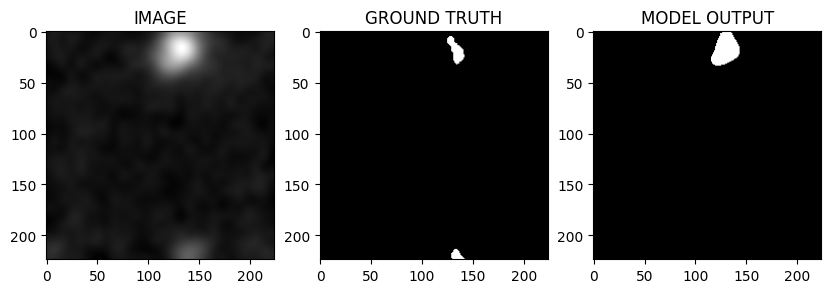

In [ ]:
helpfunc.show_image(image,mask,pred_mask.detach().cpu().squeeze(0).squeeze(0))

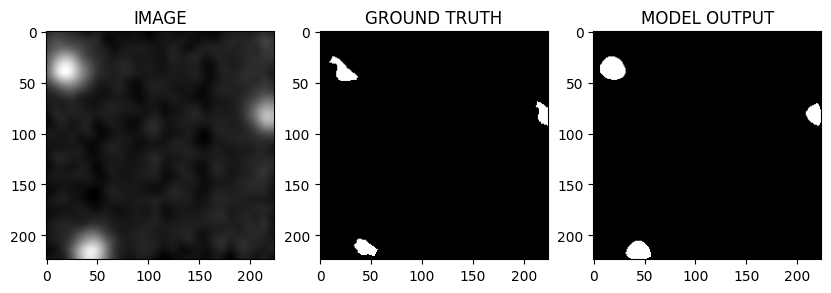

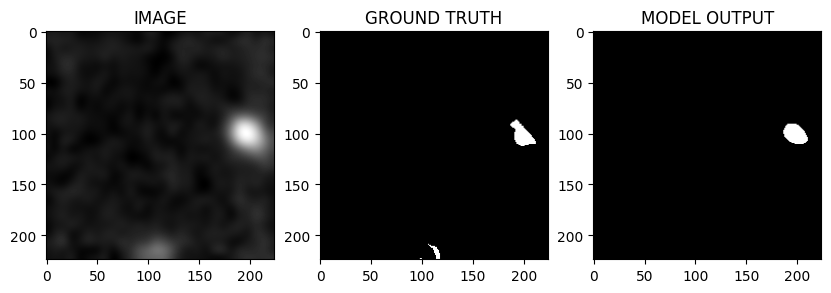

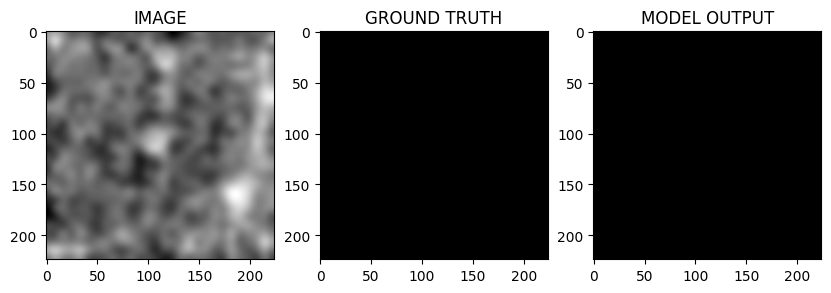

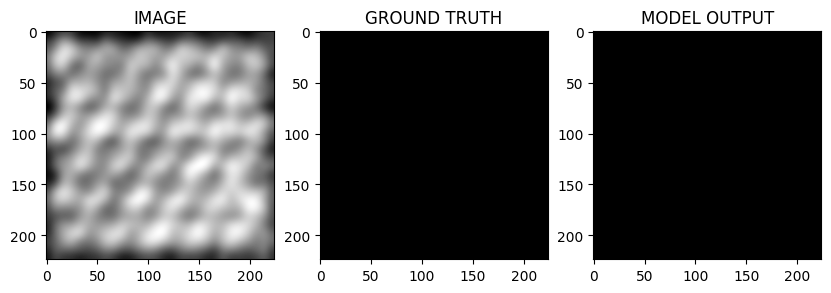

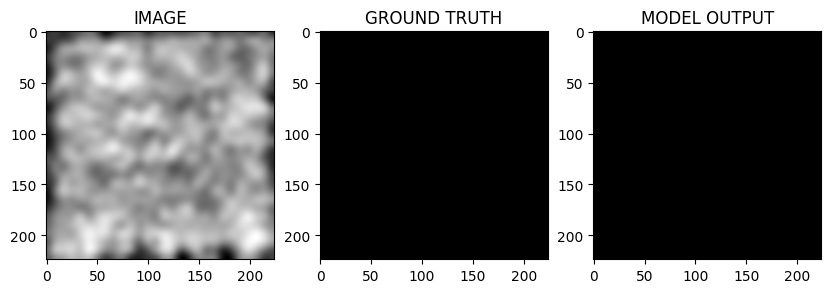

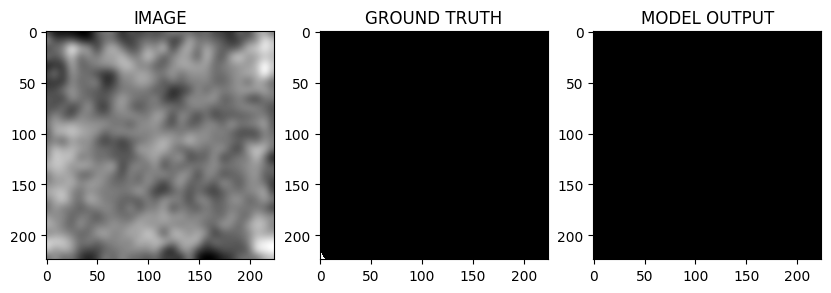

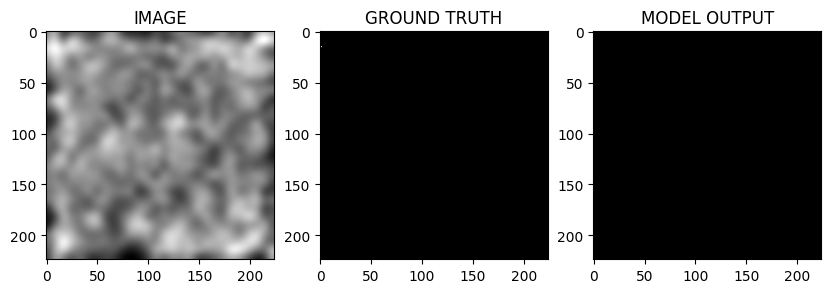

In [ ]:
for i in range(7):
  model.load_state_dict(torch.load('/content/best_model.pt'))

  image,mask = validset[i]

  logits_mask = model(image.to(DEVICE).unsqueeze(0).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask>0.5)*1.0

  helpfunc.show_image(image,mask,pred_mask.detach().cpu().squeeze(0).squeeze(0))

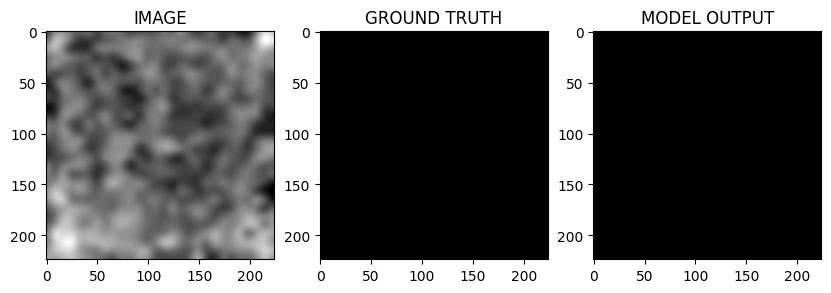

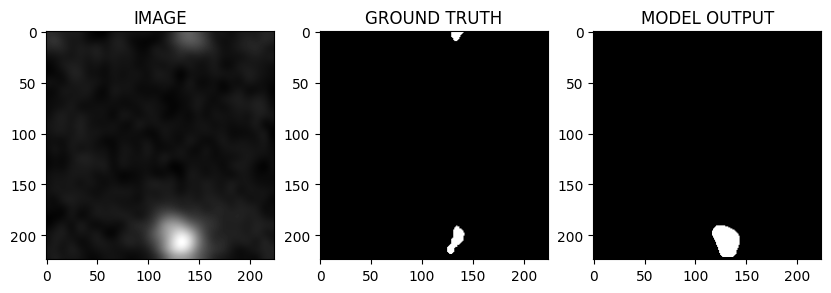

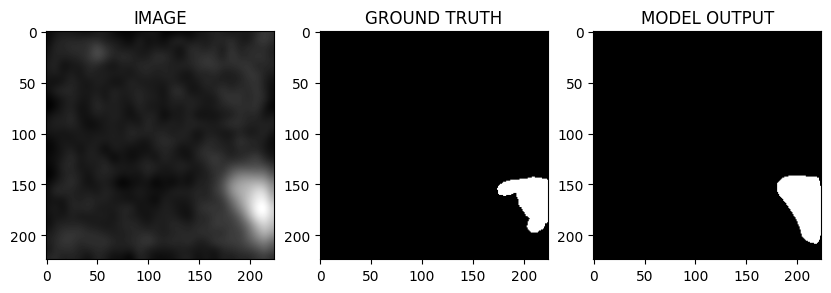

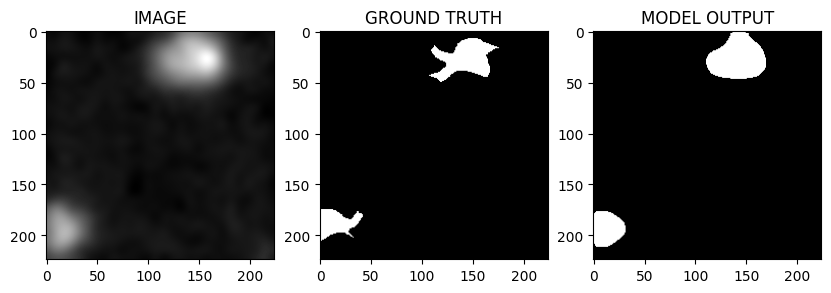

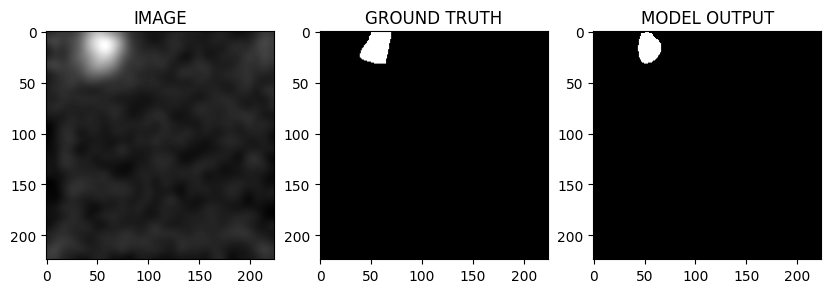

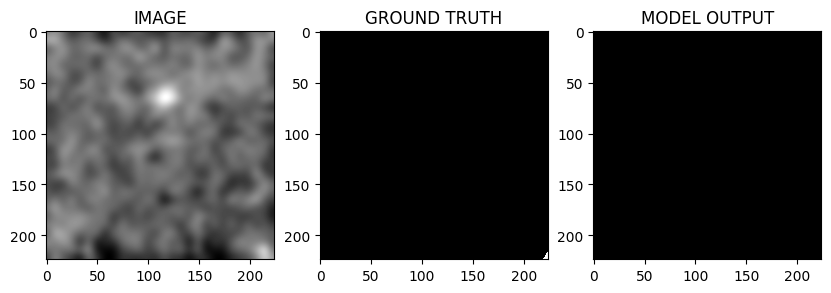

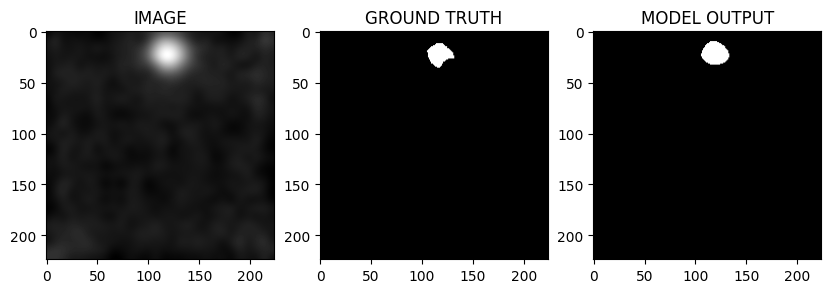

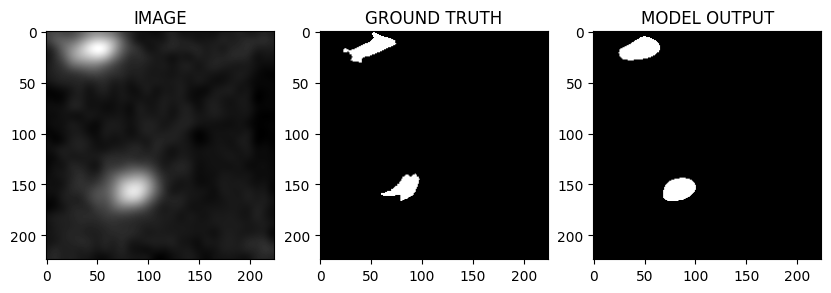

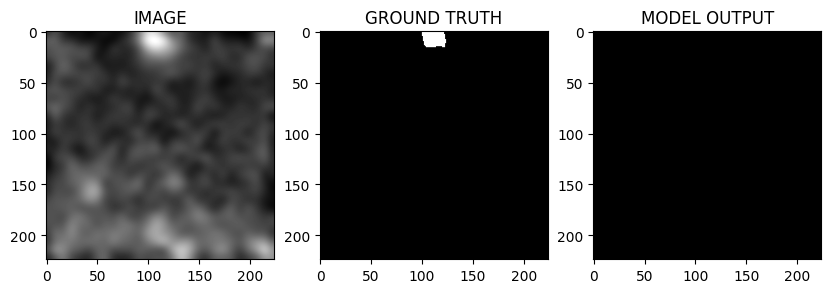

In [ ]:
for i in range(9):
  model.load_state_dict(torch.load('/content/best_model.pt'))

  image,mask = trainset[i]

  logits_mask = model(image.to(DEVICE).unsqueeze(0).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask>0.5)*1.0

  helpfunc.show_image(image,mask,pred_mask.detach().cpu().squeeze(0).squeeze(0))

In [ ]:

model.load_state_dict(torch.load('/content/best_model.pt'))

image = Image.open('/content/grid_test_bent_008.tiff')
image = np.array(image)
image = torch.Tensor(image)

logits_mask = model(image.to(DEVICE).unsqueeze(0).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

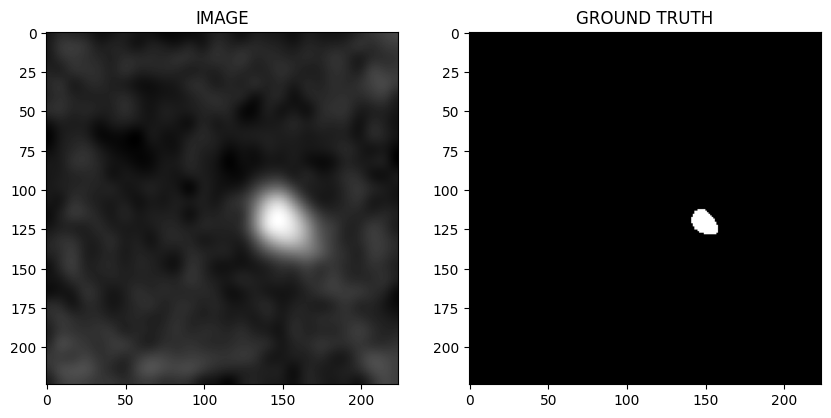

In [ ]:
helpfunc.show_image(image,pred_mask.detach().cpu().squeeze(0).squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya